In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
from random import shuffle

import matplotlib.pyplot as plt
import seaborn as sns

import data.giovanni_model.config as config
from data.giovanni_model.utils import compute_frames

/tmp/ipykernel_323120/2037661066.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import torch
from torch.utils.data import Dataset

/home/thiago/python-envs/base/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [4]:
# set device to GPU
dev = "cuda:0"

# History dataset generation

In [5]:
# load legal amazon limits
am_bounds = gpd.read_file(config.AMAZON_FRONTIER_DATA)

In [6]:
# load frames idx detail
frames_idx = pd.read_csv(config.TR_FRAMES_IDX, index_col=0)

In [7]:
# load frames deforestation area history
deforestation = pd.read_csv(config.TR_DEFORESTATION, index_col=0)
deforestation["quarter_date"] = pd.to_datetime(deforestation["quarter_date"])

In [8]:
# counties
frames_county = pd.read_csv(config.TR_COUNTIES, index_col=0)
counties_defor = pd.read_csv(config.TR_COUNTIES_DEFOR, index_col=0)

In [9]:
# precipitations
precip = pd.read_csv(config.TR_RAIN_AVG)
precip["quarter_date"] = pd.to_datetime(precip["dt"])

In [10]:
# terrain position index
tpi = pd.read_csv(config.TR_TPI, skiprows=1)\
    .rename(columns={"Unnamed: 0": "frame_id"})

In [11]:
# land cover
landcover = pd.read_csv(config.TR_LANDCOVER)
landcover = pd.pivot_table(
    landcover, 
    index=["frame_id"], 
    columns=["landcover"], 
    values="geometry", 
    aggfunc="sum"
).fillna(0).astype(int)
# convert to percentage
sum_by_frame = landcover.sum(axis=1)
for col in landcover.columns:
    landcover[col] = landcover[col] / sum_by_frame

In [12]:
# past scores
past_scores = pd.read_csv(config.TR_PAST_SCORES)
past_scores["variable"] = pd.to_datetime(past_scores["variable"])

In [13]:
# night lights
night_light = pd.read_csv(config.TR_NIGHT_LIGHT)
night_light["dt"] = pd.to_datetime(night_light["dt"])

## Create grid

In [14]:
# create limits history grid
time_grid = np.zeros((len(config.TIME_STEPS), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
for t, dt in enumerate(config.TIME_STEPS):
    defor_area = (
        deforestation[
            deforestation["quarter_date"] == dt
        ].set_index("frame_id")["area"] +\
        pd.Series(0, index=frames_idx.index)
    ).fillna(0).sort_index()
    time_grid[t, :, :] = defor_area.values.reshape(time_grid[0, :, :].shape)

In [15]:
time_grid.shape

(28, 1002, 778)

# Counties data

## Population and density

In [16]:
county_data = np.zeros((2, frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
county_data[0] = (
    frames_county.set_index("frame_id")["populacao"] +\
    pd.Series(0, index=frames_idx.index)
).fillna(0).\
    values.reshape(county_data.shape[1:])

county_data[1] = (
    frames_county.set_index("frame_id")["densidade"] +\
    pd.Series(0, index=frames_idx.index)
).fillna(0).\
    values.reshape(county_data.shape[1:])

In [17]:
county_data.shape

(2, 1002, 778)

## Deforestation

In [18]:
frames_counties_defor = pd.merge(
    counties_defor,
    frames_county[["frame_id", "county_id"]],
    on="county_id",
    how="right"
)
frames_counties_defor["quarter_date"] = pd.to_datetime(frames_counties_defor["quarter_date"])

In [19]:
# create limits history grid
counties_time_grid = np.zeros((len(config.TIME_STEPS), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
for t, dt in tqdm(enumerate(config.TIME_STEPS)):
    defor_area = (
        frames_counties_defor[
            frames_counties_defor["quarter_date"] == dt
        ].set_index("frame_id")["area"] +\
        pd.Series(0, index=frames_idx.index)
    ).fillna(0).sort_index()
    counties_time_grid[t, :, :] = defor_area.values.reshape(counties_time_grid[0, :, :].shape)

28it [00:04,  6.08it/s]


In [20]:
counties_time_grid.shape

(28, 1002, 778)

In [21]:
counties_time_grid.mean(axis=(1, 2))

array([3.64349324, 1.44976199, 0.0549576 , 0.48450147, 2.60491863,
       2.88365836, 0.72031926, 1.33401451, 1.53494971, 0.33965555,
       0.27648444, 1.19631494, 4.66534426, 0.76668875, 0.40991866,
       1.23747129, 5.29401365, 1.63759775, 0.29895257, 1.81006223,
       2.79594653, 0.80019323, 0.39995533, 1.71730521, 5.65761069,
       1.48782054, 0.33267522, 0.85901459])

# Precipitations

In [22]:
# create limits history grid
precip_time_grid = np.zeros((len(config.TIME_STEPS), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
for t, dt in tqdm(enumerate(config.TIME_STEPS)):
    precip_sum = (
        precip[
            precip["quarter_date"] == dt
        ].set_index("frame_id")["precipitation"] +\
        pd.Series(0, index=frames_idx.index)
    ).fillna(0).sort_index()
    precip_time_grid[t, :, :] = precip_sum.values.reshape(counties_time_grid[0, :, :].shape)

28it [00:03,  8.78it/s]


In [23]:
precip_time_grid.shape

(28, 1002, 778)

In [24]:
precip_time_grid.mean(axis=(1, 2))

array([186.20753427, 439.33358713, 702.3223266 , 375.96249359,
       148.5295144 , 413.0688769 , 556.53640863, 399.31430876,
       187.60811386, 429.90324523, 519.214427  , 357.56493712,
       156.44664122, 429.32615398, 496.57244939, 423.21707809,
       154.23955033, 435.23924631, 597.8020921 , 377.38891596,
       197.90357116, 537.16324421, 622.31314606, 363.67691742,
       171.62971464, 437.73113001, 604.32205076, 334.68217645])

# Terrain Position Index

In [25]:
cols = ["mean", "min", "max", "std"]
tpi_array = np.zeros((len(cols), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
for icol, col in enumerate(cols):
    v = (
        tpi.set_index("frame_id")[col] +\
        pd.Series(0, index=frames_idx.index)
    ).fillna(0).sort_index()
    tpi_array[icol, :, :] = v.values.reshape(tpi_array[0, :, :].shape)

In [26]:
tpi_array.shape

(4, 1002, 778)

In [27]:
tpi_array.max(axis=(1, 2))

array([219.        ,  74.        , 682.        , 381.16196616])

# Land Cover

In [28]:
landcover_categories = [[20], [40, 50], [180]]
landcover_array = np.zeros((len(landcover_categories), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
for i, cols in enumerate(landcover_categories):
    v = (
        landcover[cols].sum(axis=1) +\
        pd.Series(0, index=frames_idx.index)
    ).fillna(0).sort_index()
    landcover_array[i, :, :] = v.values.reshape(landcover_array[0, :, :].shape)

In [29]:
landcover_array.shape

(3, 1002, 778)

In [30]:
landcover_array.mean(axis=(1, 2))

array([0.05688078, 0.63904917, 0.01726573])

# Past scores

In [31]:
# create history grid for scores
scores_time_grid = np.zeros((len(config.TIME_STEPS), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
for t, dt in tqdm(enumerate(config.TIME_STEPS)):
    t_scores = (
        past_scores[
            past_scores["variable"] == dt
        ].set_index("frame_id")["value"] +\
        pd.Series(0, index=frames_idx.index)
    ).fillna(0).sort_index()
    scores_time_grid[t, :, :] = t_scores.values.reshape(scores_time_grid[0, :, :].shape)

28it [00:00, 36.63it/s]


In [32]:
scores_time_grid.shape

(28, 1002, 778)

In [33]:
scores_time_grid.mean(axis=(1,2))

array([0.00019113, 0.01970878, 0.03237829, 0.0303591 , 0.03254027,
       0.04184595, 0.05188484, 0.05343352, 0.05884629, 0.06810746,
       0.06716801, 0.0638416 , 0.06583015, 0.0886549 , 0.09032362,
       0.08556676, 0.08718639, 0.10840274, 0.11322395, 0.10460181,
       0.10748897, 0.11863202, 0.11653463, 0.10905149, 0.10773129,
       0.12110267, 0.12369821, 0.11544868])

# Night lights

In [34]:
# create history grid for scores
night_time_grid = np.zeros((2, len(config.TIME_STEPS), frames_idx["x"].max() - frames_idx["x"].min() + 1, frames_idx["y"].max() - frames_idx["y"].min() + 1))
for t, dt in tqdm(enumerate(config.TIME_STEPS)):
    avg_light = (
        night_light[
            night_light["dt"] == dt
        ].set_index("frame_id")["avg_light"] +\
        pd.Series(0, index=frames_idx.index)
    ).fillna(0).sort_index()
    night_time_grid[0, t, :, :] = avg_light.values.reshape(night_time_grid[0, 0, :, :].shape)
    
    max_light = (
        night_light[
            night_light["dt"] == dt
        ].set_index("frame_id")["max_light"] +\
        pd.Series(0, index=frames_idx.index)
    ).fillna(0).sort_index()
    night_time_grid[1, t, :, :] = max_light.values.reshape(night_time_grid[0, 0, :, :].shape)

28it [00:05,  4.87it/s]


In [35]:
night_time_grid.shape

(2, 28, 1002, 778)

In [36]:
night_time_grid.mean(axis=(2, 3))

array([[0.08905747, 0.06830882, 0.22108746, 0.25371302, 0.23573503,
        0.24402444, 0.21836818, 0.27173093, 0.22944489, 0.22770809,
        0.21122815, 0.18509241, 0.19214316, 0.19492029, 0.24530041,
        0.28831199, 0.29576629, 0.277734  , 0.22200173, 0.27180649,
        0.31246798, 0.27526693, 0.22154229, 0.30725574, 0.26986599,
        0.33866692, 0.27871436, 0.31843935],
       [0.26065561, 0.18529193, 0.36390337, 0.3838    , 0.40839899,
        0.41019799, 0.35407161, 0.41134814, 0.38108935, 0.37483258,
        0.35470058, 0.31806081, 0.35038354, 0.35053503, 0.37943095,
        0.41901216, 0.47711412, 0.44057947, 0.34301519, 0.41183966,
        0.49050084, 0.42313796, 0.35123893, 0.45027927, 0.47900751,
        0.50671131, 0.4252236 , 0.47823331]])

# Compute frame patches

A patch is squared set of unitary frames. The patch formation process consists in iterating through the full image on both axis computing the frames corresponding to each iteration.

In [37]:
out_condition = "both"  # deforestation | borders | both

bundle_step = 32
patches = []
for ix in tqdm(list(range(frames_idx["x"].min(), frames_idx["x"].max()+1, bundle_step))):
    fx = ix + config.INPUT_BOXES_SIZE
    for iy in range(frames_idx["y"].min(), frames_idx["y"].max()+1, bundle_step):
        fy = iy + config.INPUT_BOXES_SIZE

        iframes = frames_idx[
            (frames_idx["x"] >= ix) & 
            (frames_idx["x"] < fx) &
            (frames_idx["y"] >= iy) &
            (frames_idx["y"] < fy)
        ]
        
        if out_condition == "borders":
            if iframes["in_borders"].mean() >= 0.5:  # condition: bundle has to be at least half inside borders
                patches.append(iframes.index)
                
        elif out_condition == "deforestation":
            out_of_borders_frames = len(set(iframes.index) - set(deforestation["frame_id"].values))
            if out_of_borders_frames < len(iframes):  # condition: bundle has to contain some deforestation
                patches.append(iframes.index) 

        elif out_condition == "both":
            out_of_borders_frames = len(set(iframes.index) - set(deforestation["frame_id"].values))
            if (out_of_borders_frames < len(iframes)) and (iframes["in_borders"].mean() >= 0.5):
                patches.append(iframes.index) 

100%|██████████| 32/32 [00:25<00:00,  1.26it/s]


In [38]:
# remove patches that represent reduced regions
patches = [b for b in patches if (len(b)==len(patches[0]))]

In [39]:
len(patches)

431

In [40]:
patches[0]

Index([  288,   289,   290,   291,   292,   293,   294,   295,   296,   297,
       ...
       49356, 49357, 49358, 49359, 49360, 49361, 49362, 49363, 49364, 49365],
      dtype='int64', length=4096)

In [41]:
# generate region and check which patches intersect
region = compute_frames(am_bounds.total_bounds, config.BOX_SIDE, 200, 700, 200, 500)

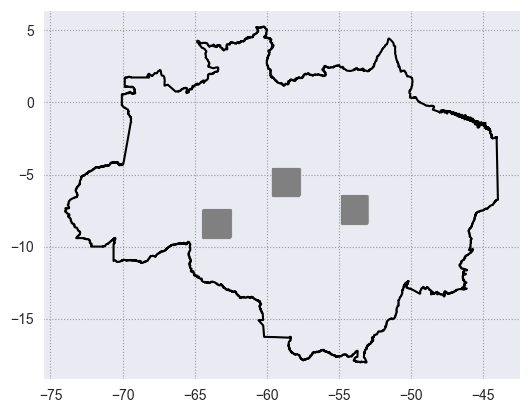

In [42]:
fig, ax = plt.subplots()
am_bounds.boundary.plot(ax=ax, color="black")
j = 0

# for i, b in enumerate(patches[100:]):
for i in [100, 200, 300]:
    b = patches[i]
    int_b = region[region["frame_id"].isin(b)]
    if len(int_b) > 0:
        int_b.boundary.plot(ax=ax, color="grey", alpha=0.5)
        j+=1
plt.show()

# Train test split

In [43]:
time_grid.shape

(28, 1002, 778)

In [44]:
train_time_idx = range(0,12)
val_time_idx = range(12,20)
test_time_idx = range(20,28)

train_data = time_grid[train_time_idx, :, :]
val_data = time_grid[val_time_idx, :, :]
test_data = time_grid[test_time_idx, :, :]

# Data Normalization

In [45]:
one_multiplicator_factor = (train_data <= 1e-7).sum() / (train_data > 1e-7).sum()

In [46]:
100 * (train_data > 1e-7).sum() / (train_data <= 1e-7).sum()

0.9898431207311943

In [47]:
norm_pop = (county_data[0, :, :] - np.median(county_data[0, :, :])) / 1e5
norm_den = (county_data[1, :, :] - np.median(county_data[1, :, :])) / 30

county_data[0, :, :] = norm_pop
county_data[1, :, :] = norm_den

In [48]:
counties_time_grid = (counties_time_grid-counties_time_grid[train_time_idx, :, :].mean()) / counties_time_grid[train_time_idx, :, :].std()

In [49]:
precip_time_grid = (precip_time_grid-precip_time_grid[train_time_idx, :, :].mean()) / precip_time_grid[train_time_idx, :, :].std()

In [50]:
for i in range(tpi_array.shape[0]):
    tpi_array[i, :, :] = (tpi_array[i, :, :] - tpi_array[i, :, :].mean()) / tpi_array[i, :, :].std()

In [51]:
for i in [0, 1]:
    s = (
        (
            night_time_grid[i, :, :, :] - 
            night_time_grid[i, train_time_idx, :, :].mean()
        ) / night_time_grid[i, train_time_idx, :, :].std()
    )
    s[np.where(s > 3)] = 3
    night_time_grid[i, :, :, :] = s.copy()

# Loss function

In [52]:
# def WeightedBinaryCrossEntropy(target, prediction):
#     return -(target*prediction.log() + (1-target)*((1-prediction).log()))

In [53]:
import torch.nn as nn
# ce_loss = nn.CrossEntropyLoss().to(dev)

In [54]:
from segmentation_models_pytorch.losses import FocalLoss

f_loss = FocalLoss("binary", gamma=3).to(dev)

# Dataset & Dataloaders

In [55]:
len(patches) * (time_grid.shape[0] - 4)

10344

In [74]:
class CustomDataset(Dataset):
    def __init__(
        self, 
        X, 
        patches, 
        frames_idx, 
        county_data=None, 
        county_defor=None,
        precip_data=None,
        tpi_data=None,
        landcover_data=None,
        scores_data=None,
        night_data=None,
        device=None,
        normalize=True
    ):
        super(CustomDataset, self).__init__()

        self.patches = patches
        self.frames_idx = frames_idx
        self.X = X
        self.county_data = county_data
        self.county_defor = county_defor
        self.precip_data = precip_data
        self.tpi_data = tpi_data
        self.landcover_data = landcover_data
        self.scores_data = scores_data
        self.night_data = night_data

        self.autor_window = 4
        self.ix = frames_idx["x"].min()
        self.iy = frames_idx["y"].min()
        
        self.device = device
        
        self.mean = None
        self.std = None
        
        # self.patches = self.patches[:20]
        
        if normalize:
            pass

    def __len__(self):
        return len(self.patches) * (self.X.shape[0]-self.autor_window)

    def __getitem__(self, index):

        # get index info
        idx_patch = index // (self.X.shape[0] - self.autor_window)
        idx_time   = index % (self.X.shape[0] - self.autor_window)
        idx_frames = self.frames_idx.loc[self.patches[idx_patch]]

        # get input
        input_matrix = self.X[
            idx_time:idx_time+self.autor_window, 
            idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
            idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
        ]
        
        # def_deter = input_matrix.copy()
        # print('DEBUG GIOVANI DATASET')
        # input_matrix[input_matrix > 1e-7] += 0.5
        # input_matrix[input_matrix <= 1e-7] = 0
        
        input_matrix = np.expand_dims(input_matrix, axis=1)
        # print(input_matrix.shape)

        if self.county_data is not None:
            # Repete os valores para cada trimestre (1, 2, 64, 64) --> (4, 2, 64, 64)
            county_data = self.county_data[np.newaxis,
                    :,
                    idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                    idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1]
            # county_data = np.expand_dims(county_data, axis=1)
            # print(county_data.shape)
            input_matrix = np.concatenate((input_matrix, np.tile(county_data, (4, 1, 1, 1))), axis=1)
            # print(input_matrix.shape)
        
        if self.county_defor is not None:
            county_defor = self.county_defor[idx_time:idx_time+self.autor_window,
                                             np.newaxis,
                                             idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                                             idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1]
            input_matrix = np.concatenate((input_matrix, county_defor), axis=1)

        
        if self.precip_data is not None:
            precip_data = self.precip_data[
                    idx_time:idx_time+self.autor_window,
                    np.newaxis,
                    idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                    idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1]
            input_matrix = np.concatenate([input_matrix, precip_data], axis=1)
        
        if self.tpi_data is not None:
            tpi_data = self.tpi_data[
                    np.newaxis,
                    :,
                    idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                    idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1]
            # print(tpi_data.shape, np.tile(tpi_data, (4, 1, 1, 1)).shape)
            # 1/0
            input_matrix = np.concatenate([input_matrix, np.tile(tpi_data, (4, 1, 1, 1))], axis=1)
        
        if self.landcover_data is not None:
            input_matrix = np.concatenate([
                input_matrix,
                self.landcover_data[
                    :,
                    idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                    idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
                ]
            ])
        
        if self.scores_data is not None:
            scores_data = self.scores_data[
                    np.newaxis,
                    [idx_time+self.autor_window],
                    idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                    idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1]
            input_matrix = np.concatenate([input_matrix, np.tile(scores_data, (4, 1, 1, 1))], axis=1)
        
        if self.night_data is not None:
            night_data = np.tile(self.night_data[
                    np.newaxis,
                    :,
                    idx_time+self.autor_window-1,
                    idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                    idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1], (4, 1, 1, 1))
            input_matrix = np.concatenate([input_matrix, night_data], axis=1)
            
        # input_matrix = np.tile(scores_data, (4, 1, 1, 1))
        data = torch.tensor(input_matrix).float() #.to(self.device)

        # get output
        labels = np.zeros(
            (   2,
                idx_frames["x"].max()-idx_frames["x"].min() + 1, 
                idx_frames["y"].max()-idx_frames["y"].min() + 1
            )
        )
        # print(idx_frames["x"].max()-idx_frames["x"].min() + 1, idx_frames["y"].max()-idx_frames["y"].min() + 1)
        # 1/0
        target_idx = np.where(
            self.X[
                idx_time+self.autor_window, 
                idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
            ] > 1e-7
        )
        
        # labels = self.X[
        #         idx_time+self.autor_window, 
        #         idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
        #         idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
        #     ]
        labels[0, :, :] = 1
        labels[0, :, :][target_idx] = 0
        labels[1, :, :][target_idx] = 1
        labels = torch.tensor(labels).float()# .to(self.device)
        # print('DEBUG')
        # print(labels.shape)
        # print(labels.unsqueeze(0).shape)
        # print(data.shape)
        # 1/0
        # return data, labels.unsqueeze(0).unsqueeze(0)
        return data, labels.unsqueeze(0)#.unsqueeze(0)

In [57]:
class CustomDataset(Dataset):
    def __init__(
        self, 
        X, 
        patches, 
        frames_idx, 
        county_data=None, 
        county_defor=None,
        precip_data=None,
        tpi_data=None,
        landcover_data=None,
        scores_data=None,
        night_data=None
    ):
        super(CustomDataset, self).__init__()

        self.patches = patches
        self.frames_idx = frames_idx
        self.X = X
        self.county_data = county_data
        self.county_defor = county_defor
        self.precip_data = precip_data
        self.tpi_data = tpi_data
        self.landcover_data = landcover_data
        self.scores_data = scores_data
        self.night_data = night_data

        self.autor_window = 4
        self.ix = frames_idx["x"].min()
        self.iy = frames_idx["y"].min()

    def __len__(self):
        return len(self.patches) * (self.X.shape[0]-self.autor_window)

    def __getitem__(self, index):

        # get index info
        idx_patch = index // (self.X.shape[0] - self.autor_window)
        idx_time   = index % (self.X.shape[0] - self.autor_window)
        idx_frames = self.frames_idx.loc[self.patches[idx_patch]]

        # get input
        input_matrix = self.X[
            idx_time:idx_time+self.autor_window, 
            idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
            idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
        ]

        if self.county_data is not None:
            input_matrix = np.concatenate([
                input_matrix,
                self.county_data[
                    :,
                    idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                    idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
                ]
            ])
        
        if self.county_defor is not None:
            input_matrix = np.concatenate([
                input_matrix,
                self.county_defor[
                    idx_time:idx_time+self.autor_window,
                    idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                    idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
                ]
            ])
        
        if self.precip_data is not None:
            input_matrix = np.concatenate([
                input_matrix,
                self.precip_data[
                    idx_time:idx_time+self.autor_window,
                    idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                    idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
                ]
            ])
        
        if self.tpi_data is not None:
            input_matrix = np.concatenate([
                input_matrix,
                self.tpi_data[
                    :,
                    idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                    idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
                ]
            ])
        
        if self.landcover_data is not None:
            input_matrix = np.concatenate([
                input_matrix,
                self.landcover_data[
                    :,
                    idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                    idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
                ]
            ])
        
        if self.scores_data is not None:
            input_matrix = np.concatenate([
                input_matrix,
                self.scores_data[
                    [idx_time+self.autor_window],
                    idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                    idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
                ]
            ])
        
        if self.night_data is not None:
            input_matrix = np.concatenate([
                input_matrix,
                self.night_data[
                    :,
                    idx_time+self.autor_window-1,
                    idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                    idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
                ]
            ])
        data = torch.tensor(input_matrix).float().to(dev)

        # get output
        labels = np.zeros(
            (
                2, 
                idx_frames["x"].max()-idx_frames["x"].min() + 1, 
                idx_frames["y"].max()-idx_frames["y"].min() + 1
            )
        )
        target_idx = np.where(
            self.X[
                idx_time+self.autor_window, 
                idx_frames["x"].min()-self.ix:idx_frames["x"].max()-self.ix+1, 
                idx_frames["y"].min()-self.iy:idx_frames["y"].max()-self.iy+1
            ] > 1e-7
        )
        labels[0, :, :] = 1
        labels[0, :, :][target_idx] = 0
        labels[1, :, :][target_idx] = 1
        labels = torch.tensor(labels).float().to(dev)
        return data, labels

In [58]:
train_data.shape, val_data.shape, test_data.shape

((12, 1002, 778), (8, 1002, 778), (8, 1002, 778))

In [59]:
# patches_sample_train = [patches[i] for i in np.random.choice(range(len(patches)), 100, replace=False)]
# patches_sample_test = [patches[i] for i in np.random.choice(range(len(patches)), 10, replace=False)]

# patches_sample_train = patches[:1]
# patches_sample_test = patches[1:2]

patches_sample_train = patches
patches_sample_val = patches

In [75]:
trainloader = torch.utils.data.DataLoader(
    CustomDataset(
        train_data, 
        patches_sample_train, 
        frames_idx, 
        county_data,
        counties_time_grid,
        precip_time_grid,
        tpi_array,
        None,
        scores_time_grid,
        night_time_grid
    ),
    batch_size=16,
    shuffle=True
)

valloader = torch.utils.data.DataLoader(
    CustomDataset(
        val_data, 
        patches_sample_val, 
        frames_idx, 
        county_data,
        counties_time_grid,
        precip_time_grid,
        tpi_array,
        None,
        scores_time_grid,
        night_time_grid
    ),
    batch_size=16,
    shuffle=True
)

In [76]:
trainloader.__len__(), valloader.__len__()

(216, 108)

# Baseline Model

Evaluate error without any model

In [77]:
# baseline: all zero
base_train_err = 0
for inputs, labels in trainloader:
    print(inputs.shape)
    print(labels.shape)
    y_pred = torch.tensor(np.zeros(labels.shape)).to(dev)
    y_pred[:, 0, :, :] = 1
    # base_train_err += ce_loss(input=y_pred, target=labels)
    base_train_err += f_loss(y_pred=y_pred, y_true=labels)
base_train_err = base_train_err / len(trainloader)

print(f"Baseline Error (Train) = {base_train_err:.6f}")

torch.Size([16, 4, 12, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 4, 12, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 4, 12, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 4, 12, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 4, 12, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 4, 12, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 4, 12, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 4, 12, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 4, 12, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 4, 12, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 4, 12, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 4, 12, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 4, 12, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 4, 12, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 4, 12, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 4, 12, 64, 64])
torch.Size([16, 1, 2, 6

In [78]:
base_val_err = 0
for inputs, labels in valloader:
    y_pred = torch.tensor(np.zeros(labels.shape)).to(dev)
    y_pred[:, 0, :, :] = 1
    # base_val_err += ce_loss(input=y_pred, target=labels)
    base_val_err += f_loss(y_pred=y_pred, y_true=labels)
base_val_err = base_val_err / len(valloader)
print(f"Baseline Error (Validation) = {base_val_err:.6f}")

Baseline Error (Validation) = 0.259600


# Model Init

In [64]:
import torch.optim as optim
import segmentation_models_pytorch as smp

In [65]:
# in_channels = 4+2+4+4+4+3+1+2
# 1 + 2 + 1 + 1 + 1 + 3 + 1 + 2
in_channels = 21
in_channels

21

In [68]:
# model = smp.Unet(
#     encoder_name="resnet34",
#     encoder_weights=None,
#     in_channels=in_channels,
#     classes=2,
# ).to(dev)
# optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [66]:
from openstl.models.simvp_model import SimVP_Model

In [84]:
# model = smp.DeepLabV3Plus(
#     encoder_name="resnet34",
#     encoder_weights=None,
#     in_channels=in_channels, 
#     classes=2,
# ).to(dev)

# # TODO: call SimVP model
in_shape = (4, 12, 64, 64)
model = SimVP_Model(in_shape=in_shape, nclasses=2).to(dev)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

DEBUG
2


In [85]:
# model.load_state_dict(torch.load(r"DeepLabV3+.pt"))

In [86]:
print(model)

SimVP_Model(
  (enc): Encoder(
    (enc): Sequential(
      (0): ConvSC(
        (conv): BasicConv2d(
          (conv): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(2, 16, eps=1e-05, affine=True)
          (act): SiLU()
        )
      )
      (1): ConvSC(
        (conv): BasicConv2d(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (norm): GroupNorm(2, 16, eps=1e-05, affine=True)
          (act): SiLU()
        )
      )
      (2): ConvSC(
        (conv): BasicConv2d(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(2, 16, eps=1e-05, affine=True)
          (act): SiLU()
        )
      )
      (3): ConvSC(
        (conv): BasicConv2d(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (norm): GroupNorm(2, 16, eps=1e-05, affine=True)
          (act): SiLU()
        )
      )
    )
  )
  (d

# Train loop

In [88]:
# train loop
model.epoch = 0
model.errs = []

In [89]:
def evaluate_model(model, dataloader):
    err = 0
    for inputs, labels in dataloader:
        y_pred = model(inputs.to(dev)).detach()
        # err += ce_loss(input=y_pred, target=labels)
        y_pred = y_pred[:, 0].contiguous().unsqueeze(1)
        err += f_loss(y_pred=y_pred, y_true=labels)
    err = err / len(dataloader)

    return err

In [90]:
def run_epoch():
    model.epoch += 1
    print(f"\nEpoch {model.epoch}")
    
    train_err = 0
    for inputs, labels in tqdm(trainloader):
        y_pred = model(inputs.to(dev))
        # loss = ce_loss(input=y_pred, target=labels)
        # print(y_pred)
        # print(labels.shape)
        # print(y_pred.shape)
        y_pred = y_pred[:, 0].contiguous().unsqueeze(1)
        # y_pred = torch.argmax(y_pred, axis=2)
        # print(y_pred.shape)
        loss = f_loss(y_pred=y_pred, y_true=labels.to(dev))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_err += loss.detach()
    train_err = train_err / len(trainloader)
    
    return train_err


def train(n_epochs):
    for epoch in range(n_epochs):
        
        # train for 1 epoch and compute error
        train_err = run_epoch()

        # compute validation error and save history            
        val_err = evaluate_model(model, valloader)
        model.errs.append([train_err, val_err])

        print(f"Epoch {model.epoch}: Train Loss = {train_err:.6f} | Validation Loss = {val_err:.6f}")

In [91]:
train(10)


Epoch 1


100%|██████████| 216/216 [00:38<00:00,  5.61it/s]


Epoch 1: Train Loss = 0.021657 | Validation Loss = 0.018331

Epoch 2


100%|██████████| 216/216 [00:38<00:00,  5.56it/s]


Epoch 2: Train Loss = 0.013167 | Validation Loss = 0.016355

Epoch 3


100%|██████████| 216/216 [00:38<00:00,  5.56it/s]


Epoch 3: Train Loss = 0.011438 | Validation Loss = 0.015451

Epoch 4


100%|██████████| 216/216 [00:39<00:00,  5.54it/s]


Epoch 4: Train Loss = 0.010459 | Validation Loss = 0.015253

Epoch 5


100%|██████████| 216/216 [00:39<00:00,  5.53it/s]


Epoch 5: Train Loss = 0.009836 | Validation Loss = 0.015555

Epoch 6


100%|██████████| 216/216 [00:38<00:00,  5.56it/s]


Epoch 6: Train Loss = 0.009274 | Validation Loss = 0.014625

Epoch 7


100%|██████████| 216/216 [00:38<00:00,  5.57it/s]


Epoch 7: Train Loss = 0.008792 | Validation Loss = 0.014589

Epoch 8


100%|██████████| 216/216 [00:39<00:00,  5.45it/s]


Epoch 8: Train Loss = 0.008213 | Validation Loss = 0.015911

Epoch 9


100%|██████████| 216/216 [00:39<00:00,  5.43it/s]


Epoch 9: Train Loss = 0.007677 | Validation Loss = 0.015552

Epoch 10


100%|██████████| 216/216 [00:38<00:00,  5.63it/s]


Epoch 10: Train Loss = 0.007078 | Validation Loss = 0.016997


Better than baseline?

In [92]:
(
    float(model.errs[-1][0] - base_train_err), 
    float(model.errs[-1][1] - base_val_err)
)

(-0.2525223022805177, -0.24260289450302935)

Learning curve

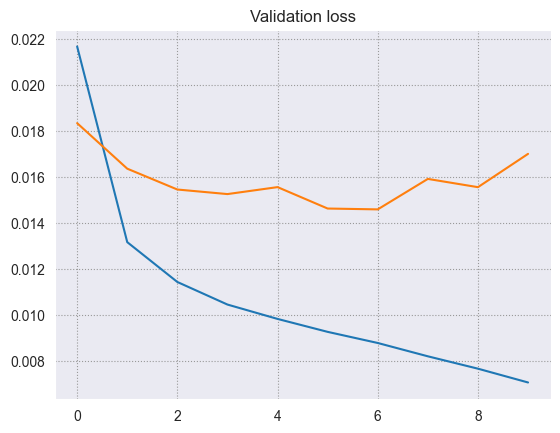

In [93]:
import matplotlib.pyplot as plt

plt.plot([float(e[0]) for e in model.errs])
plt.title("Train loss")
plt.plot([float(e[1]) for e in model.errs])
plt.title("Validation loss")
plt.show()

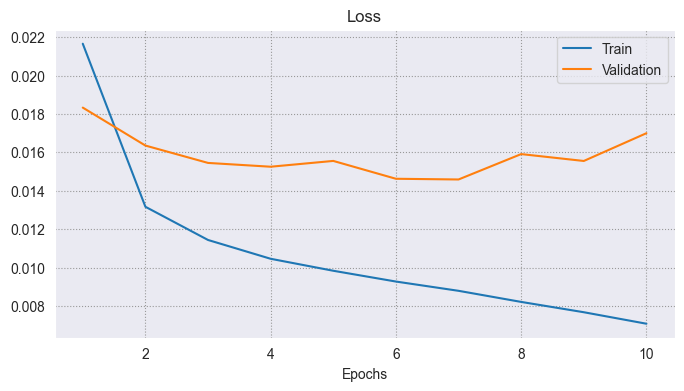

In [94]:
fig, ax = plt.subplots(figsize=(8, 4))
x = np.array(range(len(model.errs))) + 1
sns.lineplot(x=x, y=[float(e[0]) for e in model.errs], label="Train")
sns.lineplot(x=x, y=[float(e[1]) for e in model.errs], label="Validation")
ax.set_title("Loss")
ax.set_xlabel("Epochs")
plt.show()

# Test step

In [95]:
testloader = torch.utils.data.DataLoader(
    CustomDataset(
        test_data, 
        patches_sample_val, 
        frames_idx, 
        county_data,
        counties_time_grid,
        precip_time_grid,
        tpi_array,
        None,
        scores_time_grid,
        night_time_grid
    ),
    batch_size=16,
    shuffle=True
)

In [96]:
# softmax function will be needed
softmax_ = nn.Softmax(dim=2)

In [97]:
# get prediction values as binary
y_true = []
y_pred = []
for inputs, labels in testloader:
    y_hat = model(inputs.to(dev)).detach()
    print(labels.shape)
    # print(y_hat.shape)
    y_hat = y_hat[:, 0].contiguous().unsqueeze(1) # 0 is needed to only get the first channel in temporal channel
    print(y_hat.shape)
    print(labels.shape)
    y_true.append(labels[:, :, :, :, :].cpu())
    y_pred.append(softmax_(y_hat)[:, :, :, :, :].cpu())

torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 1, 2, 64, 64])
torch.Si

In [98]:
print(y_pred[0].shape)
print(y_true[0].shape)

torch.Size([16, 1, 2, 64, 64])
torch.Size([16, 1, 2, 64, 64])


In [99]:
# flatten
y_true = np.concatenate(y_true)[:, 0, 1] #.flatten() 
y_pred = np.concatenate(y_pred)[:, 0, 1] #.flatten()
print(y_true.shape, y_pred.shape)
y_true = y_true.flatten()
y_pred = y_pred.flatten()

(1724, 64, 64) (1724, 64, 64)


In [100]:
print(y_pred[54])

0.039348524


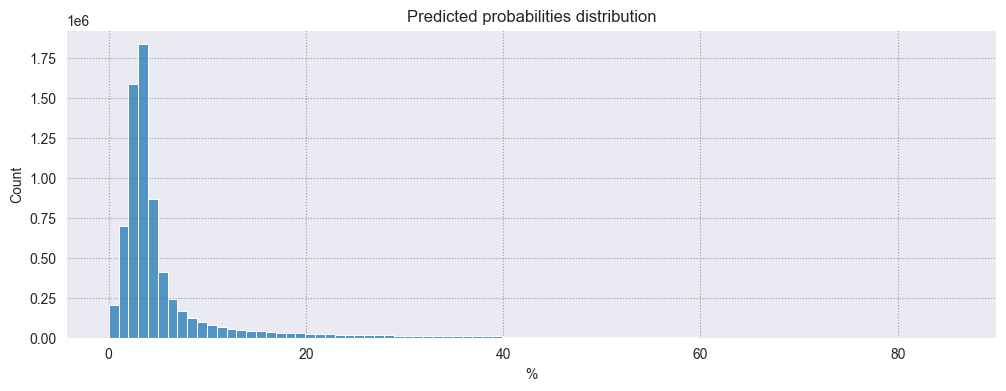

In [102]:
# get predictions distribution
fig, ax = plt.subplots(figsize=(12, 4))
sns.histplot(100*y_pred, binwidth=1, ax=ax)
ax.set_title("Predicted probabilities distribution")
ax.set_xlabel("%")
plt.show()

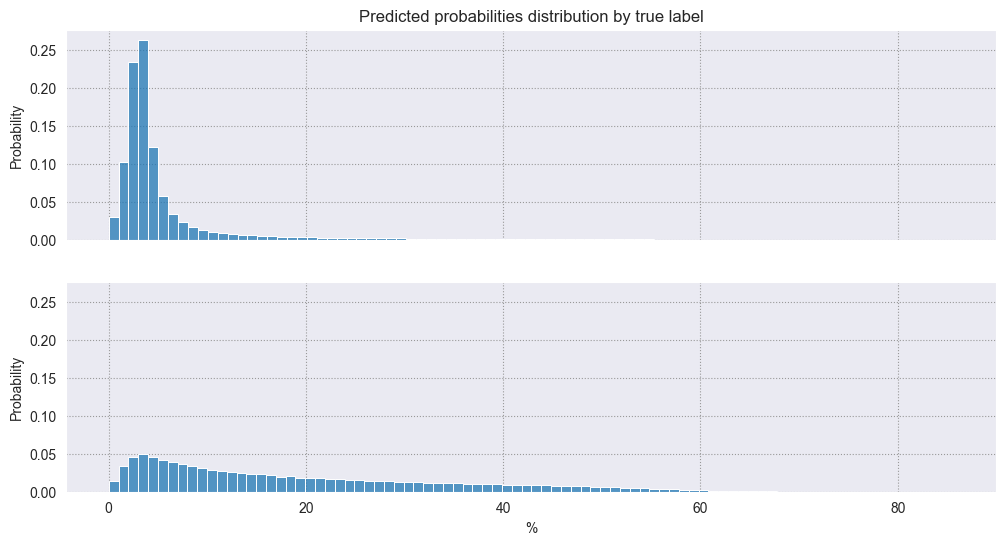

In [103]:
fig, ax = plt.subplots(2, figsize=(12, 6), sharex=True, sharey=True)
sns.histplot(100*y_pred[np.where(y_true==0)], binwidth=1, ax=ax[0], stat="probability")
sns.histplot(100*y_pred[np.where(y_true==1)], binwidth=1, ax=ax[1], stat="probability")
ax[0].set_title("Predicted probabilities distribution by true label")
ax[1].set_xlabel("%")
plt.show()

In [104]:
# select probability treshold
from sklearn.metrics import f1_score

scores = []
for p_treshold in tqdm(range(20, 40)):
    scores.append(
        f1_score(
            y_true, 
            y_pred > p_treshold / 100
        )
    )

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [01:14<00:00,  3.70s/it]


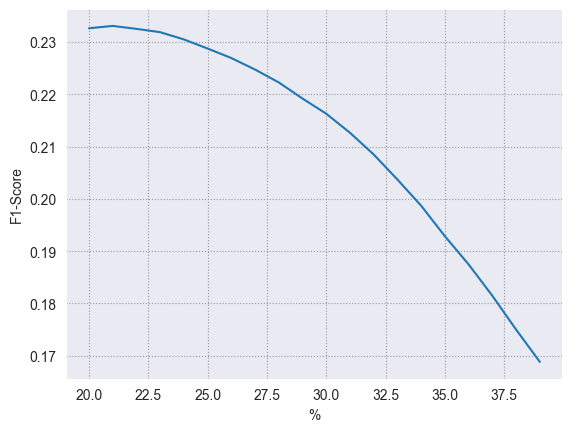

In [105]:
g = sns.lineplot(x=range(20, 40), y=scores)
g.set_xlabel("%")
g.set_ylabel("F1-Score")
plt.show()

In [107]:
# apply confusion matrix with probability treshold
p_treshold = 0.2

from sklearn.metrics import confusion_matrix
confusion_matrix(
    y_true, 
    y_pred > p_treshold,
    normalize="true"
)

array([[0.95431184, 0.04568816],
       [0.60438561, 0.39561439]])

## Old confusion matrix
array([[0.97202235, 0.02797765],
       [0.68919406, 0.31080594]])

## Validation

In [120]:
# get prediction values as binary
y_true = []
y_pred = []
for inputs, labels in valloader:
    y_hat = model(inputs).detach()
    y_true.append(labels[:, 1, :, :].cpu())
    y_pred.append(softmax_(y_hat)[:, 1, :, :].cpu())

In [121]:
# flatten
y_true = np.concatenate(y_true).flatten() 
y_pred = np.concatenate(y_pred).flatten()

In [122]:
f1_score(
    y_true, 
    y_pred > p_treshold
)

0.16481881039356847

In [123]:
confusion_matrix(
    y_true, 
    y_pred > p_treshold,
    normalize="true"
)

array([[0.98545338, 0.01454662],
       [0.85284226, 0.14715774]])

# Prediction example

In [116]:
def get_sample(min_area=0.1, dataloader=testloader):
    for input_, truth in dataloader:
        print(truth.shape)
        # print(input_.shape)
        batches = list(range(truth.shape[0])) 
        shuffle(batches)
        for idx_batch in batches:
            if truth[idx_batch, 0, 1, :, :].mean() > min_area:
                return input_, truth, idx_batch

In [117]:
input_, truth, idx_batch = get_sample(0.01, testloader)

pred = model(input_.to(dev))

torch.Size([16, 1, 2, 64, 64])


In [119]:
print(input_.shape)

torch.Size([16, 4, 12, 64, 64])


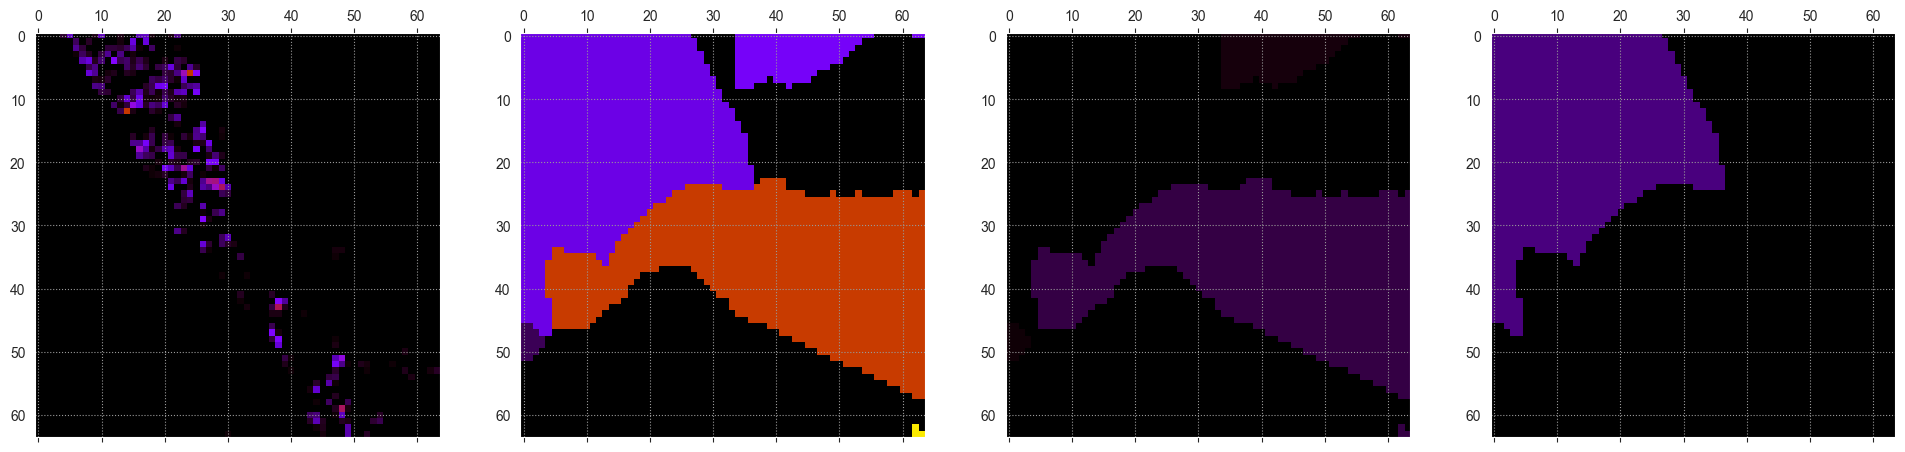

In [120]:
fig, ax = plt.subplots(1, 4, figsize=(24, 8))
for i in range(4):
    ax[i].matshow(input_[idx_batch, i, i, :, :].cpu(), cmap="gnuplot", vmin=truth.min(), vmax=truth.max())
plt.show()

C:\Users\giovanni\AppData\Local\Temp\ipykernel_6580\3254665491.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


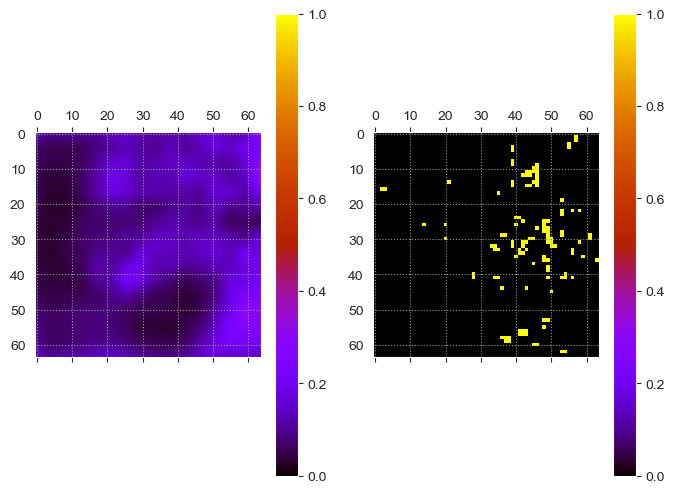

In [133]:
fig, ax = plt.subplots(1, 2, figsize=(8, 6))
m1 = ax[1].matshow(truth[idx_batch, 1, :, :].cpu(), cmap="gnuplot", vmin=truth.min(), vmax=truth.max())
m2 = ax[0].matshow(softmax_(pred).detach().cpu().numpy()[idx_batch, 1, :, :], cmap="gnuplot", vmin=truth.min(), vmax=1)
fig.colorbar(m1)
fig.colorbar(m2)
fig.show()

# Save model

In [113]:
torch.save(model.state_dict(), r"SimVP.pt")